In [1]:
import pandas as pd
import nltk
import string
import re
import h2o
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html

In [2]:
tmp_df = pd.read_csv('D:/marco/vr_chat-master/Marco/train_yn.csv')
tmp_df.head()

,passages,query,query_id,query_type,answers_yn
0,"[Row(is_selected=0, passage_text=u'In his youn...",was ronald reagan a democrat,19700,description,Yes
1,"[Row(is_selected=0, passage_text=u'So, in the ...",do game shows pay their contestants,19749,description,Yes
2,"[Row(is_selected=0, passage_text=u'Even though...",does peanut butter contain cholesterol,19761,description,No
3,"[Row(is_selected=0, passage_text=u'When turnin...",can you take left hand lane to turn right on a...,19762,description,No
4,"[Row(is_selected=0, passage_text=u'Assault on ...",is armed assault a felony,19774,description,Yes


In [3]:
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer

from nltk.stem.porter import *


In [4]:
def tf_cln(sent = tmp_df.iloc[0][0],cln=True):

    # sent = tmp_df.iloc[0][0]
    
    lowers= sent.lower()
    # print lower
    no_punctuation = lowers.translate(None, string.punctuation)
    slt_sent = re.findall(r'passagetext(.*?)url',no_punctuation)
    
    if(cln==True):
        slt_sent = re.findall(r'passage_text(.*?)url',sent)
#         print slt_sent
    else:
        slt_sent = sent
        
    token = nltk.word_tokenize(str(slt_sent))
    filtered_sentence = [w for w in token if not w in stop_words]
#     print filtered_sentence

    for i in filtered_sentence:
        if re.findall(r'^\W.*',str(i)):
    #         print re.findall(r'^\W',i)
            stop_words.add(i)
        
#     for i in re.findall(r'\W',str(filtered_sentence)):
#         stop_words.add(i)
#         print i

    stop_words.add('``')
    filtered_sentence = [w for w in token if not w in stop_words]

    tf = nltk.FreqDist(filtered_sentence)
    
    return dict(tf)

In [5]:
def get_tf_idf(dic):
    transformer = TfidfTransformer(smooth_idf=False)
    tf_idf=transformer.fit_transform(dic.values())
    return tf_idf.toarray()
#     return tf_idf

In [6]:
def convt_lst(arr):
#     a=get_tf_idf(tf_cln())
    return (pd.DataFrame(arr).iloc[0,:])

In [7]:
lst_tfidf_psg=[]
for i in tmp_df.iloc[:,0]:
    lst_tfidf_psg.append(list(convt_lst(get_tf_idf(tf_cln(i)))))

In [8]:
lst_tfidf_qry = []
for i in tmp_df.iloc[:,1]:
    lst_tfidf_qry.append(list(convt_lst(get_tf_idf(tf_cln(i,False)))))

In [9]:
tmp_df = tmp_df.replace(tmp_df['query_type'].unique(),range(0,len(tmp_df['query_type'].unique())))
tmp_df['passages'] = lst_tfidf_psg
tmp_df['query'] = lst_tfidf_qry
tmp_df = tmp_df.replace(['yes', 'no'], ['Yes', 'No'])
tmp_df = tmp_df.replace(['Yes', 'No'], ['1', '0'])

In [10]:
del(tmp_df['query_id'])

In [11]:
tmp_df.head()

,passages,query,query_type,answers_yn
0,"[0.034523833988, 0.069047667976, 0.03452383398...","[0.57735026919, 0.57735026919, 0.57735026919]",0,1
1,"[0.0283410100633, 0.510138181139, 0.1700460603...","[0.5, 0.5, 0.5, 0.5]",0,1
2,"[0.0436020720197, 0.0872041440394, 0.087204144...","[0.5, 0.5, 0.5, 0.5]",0,0
3,"[0.025515518154, 0.025515518154, 0.06378879538...","[0.333333333333, 0.333333333333, 0.33333333333...",0,0
4,"[0.0286534127531, 0.0286534127531, 0.028653412...","[0.57735026919, 0.57735026919, 0.57735026919]",0,1


In [12]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 mins 46 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,2 months and 11 days
H2O cluster name:,H2O_from_python_user_5y0yr3
H2O cluster total nodes:,1
H2O cluster free memory:,797 Mb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [ ]:
# tmp_df.iloc[0,0]
# h2o.shutdown()

In [13]:
hdf_tfidf_psg = h2o.H2OFrame(lst_tfidf_psg)
hdf_tfidf_qry = h2o.H2OFrame(lst_tfidf_qry)

hdf_tfidf = hdf_tfidf_psg.cbind(hdf_tfidf_qry)
hdf_tfidf = hdf_tfidf.cbind(h2o.H2OFrame(tmp_df[tmp_df.columns[2:3]]))


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
hdf_target = h2o.H2OFrame(pd.DataFrame(tmp_df.answers_yn))
hdf = h2o.H2OFrame.cbind(hdf_tfidf,h2o.H2OFrame.asfactor(hdf_target))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
hdf.head(1)

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200
0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.103572,0.103572,0.310715,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0690477,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.207143,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.103572,0.0690477,0.172619,0.0345238,0.0345238,0.0345238,0.103572,0.0690477,0.0345238,0.103572,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.103572,0.0345238,0.0690477,0.0345238,0.0690477,0.0690477,0.0345238,0.103572,0.0345238,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.138095,0.0690477,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.103572,0.0690477,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.207143,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.0690477,0.517858,0.0345238,0.103572,0.0345238,0.0345238,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.172619,0.0345238,0.103572,0.0690477,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.103572,0.0690477,0.0345238,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0690477,0.0345238,0.0690477,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.0345238,0.103572,0.0345238,0.0345238,0.0345238,0.0345238,0.138095,0.0345238,0.0345238,0.0345238,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [16]:
hdf_train, hdf_validate=hdf.split_frame(ratios=[0.75], seed =5010)

In [17]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [ ]:
# len(hdf.col_names)-1
# hdf.columns[0:len(hdf.col_names)-1]

In [25]:
nb =H2ONaiveBayesEstimator(seed =1)
nb.train(x = hdf.columns[0:len(hdf.col_names)-1], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [26]:
nb.auc()

0.0

In [27]:
gbm_model = H2OGradientBoostingEstimator(seed =1,  ntrees = 170, learn_rate = .05)
gbm_model.train(x = hdf.columns[0:len(hdf.col_names)-1], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


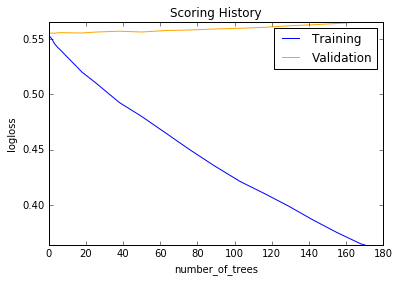

In [28]:
gbm_model.plot()

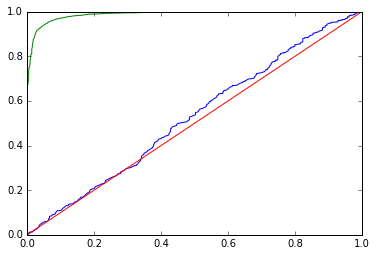

In [29]:
roc_valid = gbm_model.roc(valid=True)
roc_train= gbm_model.roc()

plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

In [21]:
dl = H2ODeepLearningEstimator(seed =1,epochs =15,hidden=[20,20,20], model_id='dl1')
dl.train(x = hdf.columns[0:len(hdf.col_names)-1], y = 'answers_yn', training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


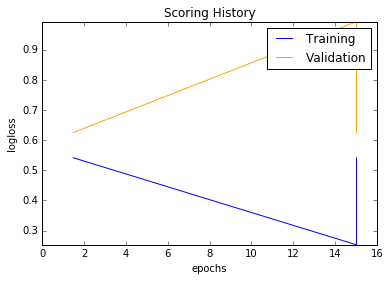

In [22]:
dl.plot()

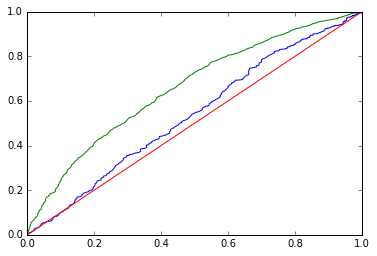

In [24]:
roc_valid = dl.roc(valid=True)
roc_train= dl.roc()

plt.plot(roc_valid[0],roc_valid[1])
plt.plot(roc_train[0],roc_train[1])
plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))

In [52]:
    print "Gradient Boosting Machine Results"
    print '=================================================================='
    print 'Training AUC:', gbm_model.auc(train=True), '| Validation AUC: ', gbm_model.auc(valid=True)

    print "\nDeep Learning Results"
    print '=================================================================='
    print 'Training AUC:', dl.auc(train=True), '| Validation AUC: ', dl.auc(valid=True)


Gradient Boosting Machine Results
Training AUC: 0.98792935448 | Validation AUC:  0.526059892685

Deep Learning Results
Training AUC: 0.65851085125 | Validation AUC:  0.536532629213
